In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np


import time

In [2]:
import sys
sys.path += ["../../../particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

import tensorflow as tf
import tensorflow_datasets as tfds

import pathlib

2024-02-01 07:36:00.018214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 07:36:00.223574: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 07:36:00.223603: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 07:36:00.224658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 07:36:00.305531: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 07:36:00.307011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../tensorflow_datasets/') # Tensorflow datsets positions in the lxplus
dss = ds_builder.as_data_source("test")

In [4]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [5]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)

In [6]:
output_signature

{'X': TensorSpec(shape=(None, 17), dtype=tf.float32, name=None),
 'ycand': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None),
 'ygen': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)}

In [7]:
data = list(tfds.as_numpy(tf_dataset))

In [8]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

In [9]:
ys[0][9][:,:4]

array([[ 1.        , -1.        ,  3.5555263 ,  0.22640967],
       [ 1.        , -1.        ,  2.4462407 ,  0.195159  ],
       [ 1.        ,  1.        ,  0.8356094 , -0.5446882 ],
       [ 1.        ,  1.        ,  0.85157084, -1.37132   ],
       [ 1.        ,  1.        ,  0.6311886 , -0.9460032 ],
       [ 1.        ,  1.        ,  0.560444  , -0.38950145],
       [ 1.        , -1.        ,  0.50040615, -0.29128084],
       [ 1.        , -1.        ,  0.40326795,  0.19255948],
       [ 1.        ,  1.        ,  0.37885737,  0.12188682],
       [ 1.        , -1.        ,  0.36663368, -2.1641972 ],
       [ 1.        ,  1.        ,  0.3846691 ,  0.68863004],
       [ 1.        ,  1.        ,  0.3615032 , -0.81029856],
       [ 1.        , -1.        ,  0.18166022,  0.15179   ],
       [ 1.        , -1.        ,  0.21182844,  1.8761586 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        , -1.        ,  0.16170818, -0.88895464],
       [ 1.        ,  1.

In [10]:
#batch 0, max 111 particles per event
Xs[0].shape

(10, 111, 17)

In [11]:
#batch 3 has 10 events, max 90 particles per event
Xs[3].shape

(10, 90, 17)

In [12]:
# Check the lengths of sublists in Xs
sublist_lengths = [len(sublist) for sublist in Xs]
print("Lengths of sublists in Xs:", sublist_lengths)


Lengths of sublists in Xs: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [13]:
for X_q in Xs:
    print("Shape of X_q:", X_q.shape) 

Shape of X_q: (10, 111, 17)
Shape of X_q: (10, 186, 17)
Shape of X_q: (10, 142, 17)
Shape of X_q: (10, 90, 17)
Shape of X_q: (10, 111, 17)
Shape of X_q: (10, 195, 17)
Shape of X_q: (10, 100, 17)
Shape of X_q: (10, 81, 17)
Shape of X_q: (10, 130, 17)
Shape of X_q: (10, 147, 17)


In [14]:
for y_q in ys:
    print("Shape of yq:", y_q.shape)

Shape of yq: (10, 111, 8)
Shape of yq: (10, 186, 8)
Shape of yq: (10, 142, 8)
Shape of yq: (10, 90, 8)
Shape of yq: (10, 111, 8)
Shape of yq: (10, 195, 8)
Shape of yq: (10, 100, 8)
Shape of yq: (10, 81, 8)
Shape of yq: (10, 130, 8)
Shape of yq: (10, 147, 8)


## Quantizing the model

Quantizing with post-training dynamic range quantization.
Using the TensorFlow Lite Converter, you can now convert the trained model into a TensorFlow Lite model.



In [15]:
config, _ = parse_config("../../../particleflow/parameters/clic.yaml") #positions on the lxplus
model = make_model(config, tf.float32)
Xdummy = np.zeros((1,256,17), dtype=np.float32)
model(Xdummy)
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)

In [16]:
def model_output(ret):
    return tf.concat(
        [
            ret["cls"], #0-5
            ret["charge"], #6-8
            ret["pt"], #9
            ret["eta"], #10
            ret["sin_phi"], #11
            ret["cos_phi"], #12
            ret["energy"], #13
        ],
        axis=-1,
    )

full_model = tf.function(lambda x: model_output(model(x, training=False)))

In [17]:
start_time = time.time()
true_pts = []
pred_pts = []
#loop over batches
for i in range(len(Xs)):
    ret = full_model(Xs[i])
    msk_true_part = ys[i][..., 0]!=0
    true_pts.append(ys[i][msk_true_part][..., 2])
    pred_pts.append(ret[msk_true_part][..., 9])
true_pts = np.hstack(true_pts)
pred_pts = np.hstack(pred_pts)

end_time = time.time()
inference_time_unquantized = end_time - start_time
print("Inference time for unquantized model:", inference_time_unquantized, "seconds")


Inference time for unquantized model: 21.212756156921387 seconds


Text(0, 0.5, 'predicted pt')

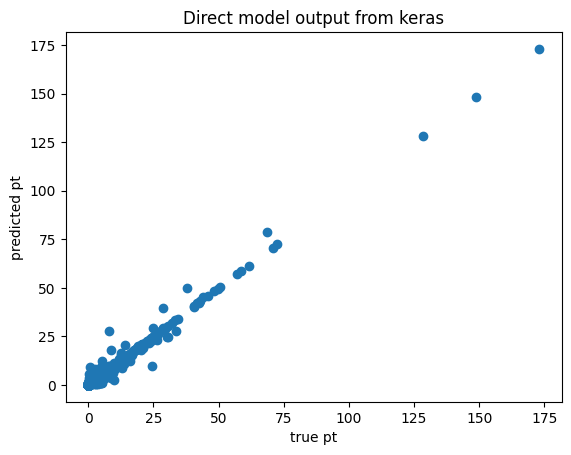

In [18]:
plt.title("Direct model output from keras")
plt.scatter(true_pts, pred_pts)
plt.xlabel("true pt")
plt.ylabel("predicted pt")

## Dynamic Range Quantiztion
* 4x smaller, 2x-3x speedup
* Reduced size upto 75%
* There are smallest accuracy loss

Source:
1. https://www.tensorflow.org/lite/performance/post_training_quantization

In [19]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([full_model.get_concrete_function(Xdummy)])
tflite_model = converter.convert()

2024-02-01 07:36:29.044414: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-01 07:36:29.044527: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-01 07:36:32.104585: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-01 07:36:32.104853: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-01 07:36:32.766367: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2245] Estimated count of arithmetic ops: 2.916 G  ops, equivalently 1.458 G  MACs


Write it out to a tflite file:



In [20]:
tflite_models_dir = pathlib.Path("/tmp/working1_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [21]:
tflite_model_file = tflite_models_dir/"working1_tflite_models.tflite"
tflite_model_file.write_bytes(tflite_model)

22468840

To quantize the model on export, set the optimizations flag to optimize for size:



In [22]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"working_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)


2024-02-01 07:36:34.365576: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-01 07:36:34.365664: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-01 07:36:37.052577: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-01 07:36:37.052603: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-01 07:36:38.375294: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2245] Estimated count of arithmetic ops: 2.916 G  ops, equivalently 1.458 G  MACs


6126520

As expected the resulting file, is approximately 1/4 the size.



Run the TFLite models



Test the model on the quantized data: https://www.tensorflow.org/lite/performance/post_training_quant



In [23]:
start_time = time.time()

true_pts = []
pred_pts = []
pred_pts_quantized = []

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
input_index1 = interpreter.get_input_details()[0]["index"]
output_index1 = interpreter.get_output_details()[0]["index"]

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()
input_index2 = interpreter_quant.get_input_details()[0]["index"]
output_index2 = interpreter_quant.get_output_details()[0]["index"]

for ibatch in range(len(Xs)):
#for ibatch in range(5):
    for iev in range(len(Xs[ibatch])):

        this_X = tf.expand_dims(Xs[ibatch][iev], 0)
        pad_size = [[0,0],[0,Xdummy.shape[1]-this_X.shape[1]], [0,0]]
        this_X = tf.pad(this_X, pad_size)
        this_ys = tf.pad(ys[ibatch][iev], pad_size[1:])
        
        interpreter.set_tensor(input_index1, this_X)
        interpreter.invoke()
        
        interpreter_quant.set_tensor(input_index2, this_X)
        interpreter_quant.invoke()
        
        mask_true_particles = this_ys[..., 0] != 0
        true_pt = this_ys[mask_true_particles][..., 2]
        output1 = interpreter.tensor(output_index1)()[0][mask_true_particles][..., 9]
        output2 = interpreter_quant.tensor(output_index2)()[0][mask_true_particles][..., 9]
        
        true_pts.append(true_pt)
        pred_pts.append(output1)
        pred_pts_quantized.append(output2)
        
        
end_time = time.time()
inference_time_quantized = end_time - start_time
print("Inference time for quantized model:", inference_time_quantized, "seconds")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Inference time for quantized model: 24.239319801330566 seconds


In [24]:
interpreter.get_input_details()

[{'name': 'x',
  'index': 0,
  'shape': array([  1, 256,  17], dtype=int32),
  'shape_signature': array([  1, 256,  17], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [25]:
interpreter.get_output_details()


[{'name': 'Identity',
  'index': 1546,
  'shape': array([  1, 256,  14], dtype=int32),
  'shape_signature': array([  1, 256,  14], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [26]:
flat_true_pts = np.hstack(true_pts)
flat_pred_pts = np.hstack(pred_pts)
flat_pred_pts_quantized = np.hstack(pred_pts_quantized)

In [27]:
flat_true_pts.shape, flat_pred_pts.shape, flat_pred_pts_quantized.shape

((4250,), (4250,), (4250,))

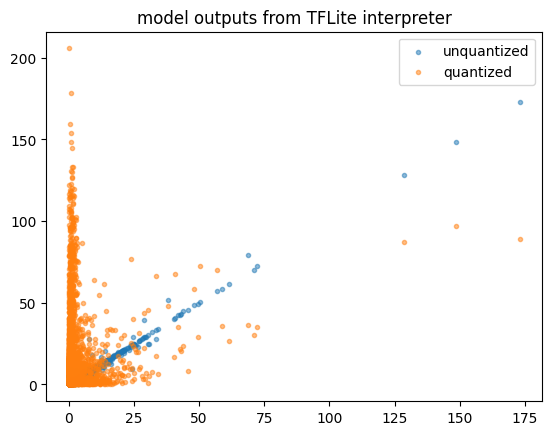

In [28]:
plt.title("model outputs from TFLite interpreter")
plt.scatter(flat_true_pts, flat_pred_pts, label="unquantized", marker=".", alpha=0.5)
plt.scatter(flat_true_pts, flat_pred_pts_quantized, label="quantized", marker=".", alpha=0.5)
plt.legend(loc="best")

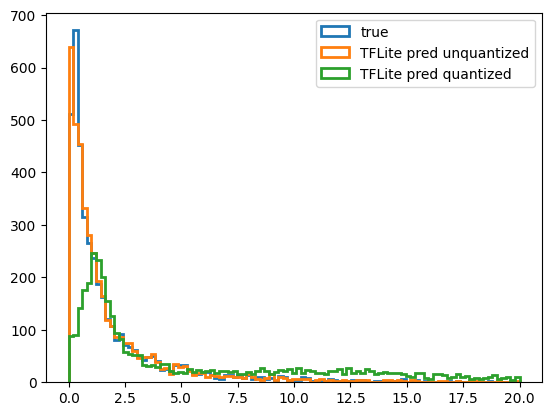

In [29]:
plt.hist(flat_true_pts, bins=np.linspace(0,20,100), histtype="step", label="true", lw=2);
plt.hist(flat_pred_pts, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred unquantized", lw=2);
plt.hist(flat_pred_pts_quantized, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred quantized", lw=2);
plt.legend(loc="best")

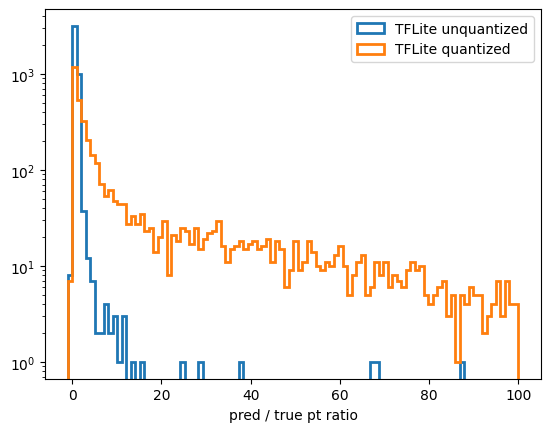

In [30]:
plt.hist(flat_pred_pts/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite unquantized")
plt.hist(flat_pred_pts_quantized/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite quantized")
#plt.axvline(1.0, color="black")
plt.yscale("log")
plt.xlabel("pred / true pt ratio")
plt.legend()

## Fp16 quantization 

* Representative Data is not required for this type of Quantization
* Supported Hardware: CPU, GPU
    
    
The advantages of float16 quantization are as follows:

* It reduces model size by up to half (since all weights become half of their original size).
* It causes minimal loss in accuracy.
* It supports some delegates (e.g. the GPU delegate) which can operate directly on float16 data, resulting in faster execution than float32 computations.

The disadvantages of float16 quantization are as follows:

* It does not reduce latency as much as a quantization to fixed point math.
* By default, a float16 quantized model will "dequantize" the weights values to float32 when run on the CPU. (Note that the GPU delegate will not perform this dequantization, since it can operate on float16 data.)

Source: 
* https://www.tensorflow.org/lite/performance/post_training_quantization#float16_quantization
* https://www.tensorflow.org/lite/performance/post_training_float16_quant
* https://www.tensorflow.org/lite/performance/model_optimization
    

In [31]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([full_model.get_concrete_function(Xdummy)])
tflite_model = converter.convert()

2024-02-01 07:37:04.616928: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-01 07:37:04.617039: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-01 07:37:07.856772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-01 07:37:07.856799: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-01 07:37:08.477585: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2245] Estimated count of arithmetic ops: 2.916 G  ops, equivalently 1.458 G  MACs


In [32]:
# Writing the model to a `.tflite` file
tflite_models_dir = pathlib.Path("/tmp/working1_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"working1_tflite_models.tflite"
tflite_model_file.write_bytes(tflite_model)

22468840

To istead quantize the model to float 16 on export, first set the `optimizations` flag to use default optimizations. Then specify that float16 is the supported type on the target platform 

Source:
1. https://www.tensorflow.org/lite/performance/post_training_float16_quant

In [33]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

Finally, convert the model like usual. Note, by default the converted model will still use float input and outputs for invocation convenience.



In [34]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"working_model_quant_fp16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

2024-02-01 07:37:09.700413: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-01 07:37:09.700501: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-01 07:37:13.154662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-01 07:37:13.154692: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-01 07:37:13.857320: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2245] Estimated count of arithmetic ops: 2.916 G  ops, equivalently 1.458 G  MACs


11428456

Note how the resulting file is approximately `1/2` the size

In [35]:
ls -lh {tflite_models_dir}

total 39M
-rw-rw-r-- 1 shivam-raj shivam-raj  22M Feb  1 07:37 working1_tflite_models.tflite
-rw-rw-r-- 1 shivam-raj shivam-raj  11M Feb  1 07:37 working_model_quant_fp16.tflite
-rw-rw-r-- 1 shivam-raj shivam-raj 5.9M Feb  1 07:36 working_model_quant.tflite


In [36]:
start_time = time.time()
true_pts = []
pred_pts = []
pred_pts_quantized = []

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
input_index1 = interpreter.get_input_details()[0]["index"]
output_index1 = interpreter.get_output_details()[0]["index"]

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_quant.allocate_tensors()
input_index2 = interpreter_quant.get_input_details()[0]["index"]
output_index2 = interpreter_quant.get_output_details()[0]["index"]

for ibatch in range(len(Xs)):
#for ibatch in range(5):
    for iev in range(len(Xs[ibatch])):

        this_X = tf.expand_dims(Xs[ibatch][iev], 0)
        pad_size = [[0,0],[0,Xdummy.shape[1]-this_X.shape[1]], [0,0]]
        this_X = tf.pad(this_X, pad_size)
        this_ys = tf.pad(ys[ibatch][iev], pad_size[1:])
        
        interpreter.set_tensor(input_index1, this_X)
        interpreter.invoke()
        
        interpreter_quant.set_tensor(input_index2, this_X)
        interpreter_quant.invoke()
        
        mask_true_particles = this_ys[..., 0] != 0
        true_pt = this_ys[mask_true_particles][..., 2]
        output1 = interpreter.tensor(output_index1)()[0][mask_true_particles][..., 9]
        output2 = interpreter_quant.tensor(output_index2)()[0][mask_true_particles][..., 9]
        
        true_pts.append(true_pt)
        pred_pts.append(output1)
        pred_pts_quantized.append(output2)
        
end_time = time.time()
inference_time_quantized = end_time - start_time
print("Inference time for quantized model:", inference_time_quantized, "seconds")


Inference time for quantized model: 15.39766788482666 seconds


In [37]:
interpreter.get_input_details()

[{'name': 'x',
  'index': 0,
  'shape': array([  1, 256,  17], dtype=int32),
  'shape_signature': array([  1, 256,  17], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [38]:
interpreter.get_output_details()

[{'name': 'Identity',
  'index': 1546,
  'shape': array([  1, 256,  14], dtype=int32),
  'shape_signature': array([  1, 256,  14], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [39]:
flat_true_pts = np.hstack(true_pts)
flat_pred_pts = np.hstack(pred_pts)
flat_pred_pts_quantized = np.hstack(pred_pts_quantized)

In [40]:
flat_true_pts.shape, flat_pred_pts.shape, flat_pred_pts_quantized.shape

((4250,), (4250,), (4250,))

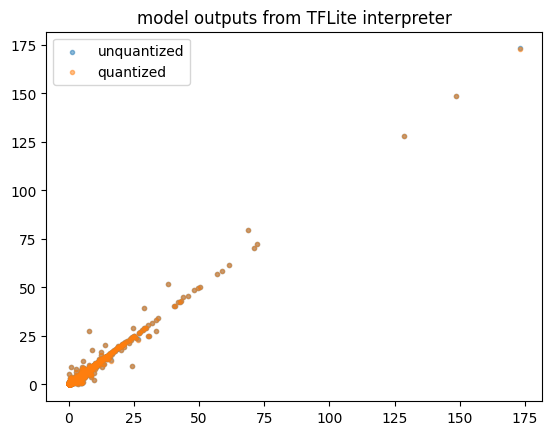

In [41]:
plt.title("model outputs from TFLite interpreter")
plt.scatter(flat_true_pts, flat_pred_pts, label="unquantized", marker=".", alpha=0.5)
plt.scatter(flat_true_pts, flat_pred_pts_quantized, label="quantized", marker=".", alpha=0.5)
plt.legend(loc="best")

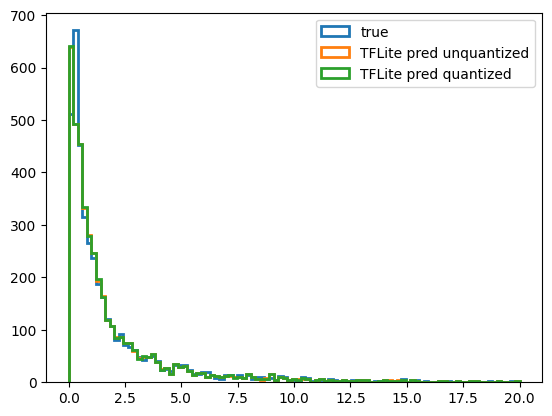

In [42]:
plt.hist(flat_true_pts, bins=np.linspace(0,20,100), histtype="step", label="true", lw=2);
plt.hist(flat_pred_pts, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred unquantized", lw=2);
plt.hist(flat_pred_pts_quantized, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred quantized", lw=2);
plt.legend(loc="best")

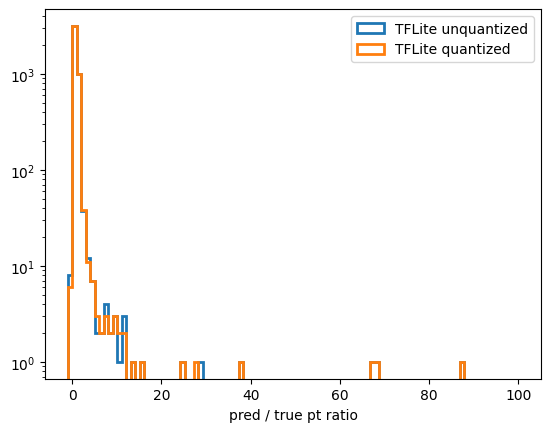

In [43]:
plt.hist(flat_pred_pts/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite unquantized")
plt.hist(flat_pred_pts_quantized/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite quantized")
# plt.axvline(1.0, color="black")
plt.yscale("log")
plt.xlabel("pred / true pt ratio")
plt.legend()